## 训练误差和泛化误差
1. 训练误差: 模型在训练数据上的误差
2. 泛化误差: 模型在新数据上的误差
### 验证数据集和测试数据集
* 验证数据集: 一个用来评估模型好坏的数据集
    * 例如拿出50%的训练数据
    * 不要和训练数据混在一起
* 测试数据集: 只能用一次的数据集. 例如:
    * 未来的考试
    * 出价的房子实际成交价
### K-则交叉验证
* 在没有足够数据时使用(常态):
* 算法:
    * 将训练数据分割为K块
    * for i = 1, ... , K
        * 使用i块作为验证数据集,其余作为训练数据集
    * 报告K个验证集的误差的平均
* 常用: K = 5 或 10
## 总结
* 训练数据集: 训练模型参数
* 验证数据集: 选择模型超参数
* 非大数据集上通常使用K-则交叉验证

## 过拟合和欠拟合 overfitting underfitting

### 模型容量
* 拟合各种函数的能力
* 低容量的模型很难拟合训练数据
* 高容量的模型可以记住所有的训练数据
![拟合程度](pic/1101.png)
### 估计模型容量
* 难以在不同的种类算法之间比较
    * 例如树模型和神经网络
* 给定一个模型种类,酱油两个主要因素
    * 参数的个数
    * 参数值的选择范围
### 数据复杂度
* 多个重要因素:
    * 样本个数
    * 每个样本的元素个数
    * 时间空间结构
    * 多样性

### 生成数据集

首先，我们需要数据。给定$x$，我们将[**使用以下三阶多项式来生成训练和测试数据的标签：**]

(**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$**)

噪声项$\epsilon$服从均值为0且标准差为0.1的正态分布。在优化的过程中，我们通常希望避免非常大的梯度值或损失值。这就是我们将*特征*从$x^i$调整为$\frac{x^i}{i!}$的原因，这样可以避免很大的$i$带来的特别大的指数值。我们将为训练集和测试集各生成100个样本。

In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [6]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [7]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.6405],
         [-0.3245]]),
 tensor([[ 1.0000e+00,  6.4052e-01,  2.0513e-01,  4.3797e-02,  7.0132e-03,
           8.9841e-04,  9.5908e-05,  8.7758e-06,  7.0264e-07,  5.0006e-08,
           3.2030e-09,  1.8650e-10,  9.9549e-12,  4.9049e-13,  2.2440e-14,
           9.5823e-16,  3.8360e-17,  1.4453e-18,  5.1431e-20,  1.7338e-21],
         [ 1.0000e+00, -3.2453e-01,  5.2660e-02, -5.6966e-03,  4.6218e-04,
          -2.9998e-05,  1.6225e-06, -7.5223e-08,  3.0515e-09, -1.1003e-10,
           3.5709e-12, -1.0535e-13,  2.8492e-15, -7.1126e-17,  1.6488e-18,
          -3.5671e-20,  7.2353e-22, -1.3812e-23,  2.4902e-25, -4.2535e-27]]),
 tensor([5.4582, 4.3179]))

In [8]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

现在[**定义训练函数**]。


In [10]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.999531   1.2110572 -3.4043598  5.544574 ]]


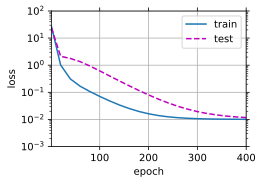

In [11]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### [**线性函数拟合(欠拟合)**]

让我们再看看线性函数拟合。在经历了早期的下降之后，进一步减少该模型的训练损失变得困难。在最后一个迭代周期完成后，训练损失仍然很高。当用来拟合非线性模式（如这里的三阶多项式函数）时，线性模型容易欠拟合。

weight: [[2.9969592 5.148389 ]]


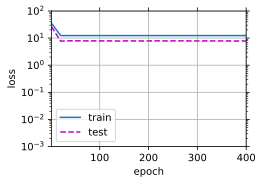

In [13]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### [**高阶多项式函数拟合(过拟合)**]

现在，让我们尝试使用一个阶数过高的多项式来训练模型。在这种情况下，没有足够的数据用于学到高阶系数应该具有接近于零的值。因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响。虽然训练损失可以有效地降低，但测试损失仍然很高。结果表明，复杂模型对数据造成了过拟合。


weight: [[ 4.9761086   1.2709095  -3.3030052   5.260437   -0.29557583  0.72916746
   0.22147018  0.10477233 -0.16592069  0.07630297 -0.07105423  0.21260256
   0.08451319 -0.01388463 -0.2176628  -0.12448299  0.032408    0.05240956
  -0.05892336 -0.11403456]]


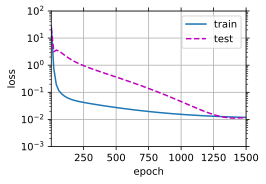

In [14]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)